In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choices
from itertools import chain
# Levenshtein Distance in Python
import textdistance
import re
import unicodedata
import time
from rank_bm25 import BM25Okapi, BM25L
# https://github.com/seatgeek/thefuzz
from thefuzz import fuzz, process

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

### Load grouftruth dataset

In [2]:
matches_training_df = pd.read_parquet('matches_training.parquet')

In [3]:
# set random seed
np.random.seed(seed=42)

### Offers training

In [4]:
#offers_training_df = pd.read_parquet('offers_training.parquet')
#offers_test_df = pd.read_parquet('offers_test.parquet')

### Run utils script
Loads functions for exploration and metrics

In [5]:
%run ./utils.py

## Brand analysis

### Brand text processing
- Lower case text
- Accented vowels removal `è, é, ... -> e`
- Stop words removal (German)

In [6]:
stop_word_list = []

with open('german_stopwords.txt', "r") as f:
    stop_word_list = f.read().split()

In [7]:
class TextTransformer:
    def processed_text(self, text):
        if text is None:
            return ''
        #lower
        processed = text.lower()
        #remove accents
        processed = self.simplify(processed)
        #remove special characters
        processed = ''.join(c if c.isalnum() or c == ' ' else ' ' for c in processed)
        #remove unnecessary double spaces
        processed = re.sub(' +', ' ', processed)
        #strip
        processed = processed.strip()
        #remove stopwords
        processed_list = [word for word in processed.split() if word not in stop_word_list]
        return ' '.join(processed_list)
    
    def simplify(self, text):
        try:
            text = unicode(text, 'utf-8')
        except NameError:
            pass
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        return str(text)

### Read files for german colors transformation

In [8]:
with open('color_processing/kfix_de.txt') as f:
    color_kfix_list = f.read().splitlines() 

with open('color_processing/primary_colors_de.txt') as f:
    primary_colors = f.read().splitlines() 
color_matches = {}
with open('color_processing/color_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        color_matches[key] = val

### Read files for german titles transformation

In [9]:
with open('title_processing/kfix_de.txt') as f:
    clothes_kfix_list = f.read().splitlines() 

with open('title_processing/primary_clothes_de.txt') as f:
    primary_clothes = f.read().splitlines() 
clothes_matches = {}
with open('title_processing/clothes_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        clothes_matches[key] = val

In [10]:
class SpecificTrasformer(TextTransformer):
    def __init__(self,
                 kfix_list, 
                 matches, 
                 primary):
        self.kfix_list = kfix_list
        self.matches = matches
        self.primary = primary
    def separe_word(self, text, word):
        i = text.find(word)
        text = text[:i] + ' ' + text[i:] if i != -1 else text
        return text[:i+len(word)+1] + ' ' + text[i+len(word)+1:] if i != -1 else text
    def separe_words(self, text):
        for color in self.primary:
            text = self.separe_word(text, color)
        return text
    def replace_words(self, text):
        for k, v in self.matches.items():
            text = text.replace(k, v)
        return text
    def remove_kfix(self, text):
        for suffix in self.kfix_list:
            text = text.replace(suffix, '')
        return text
    
    def processed_text(self, text):
        splitted = super().processed_text(text).split()
        #1 transform matches
        splitted = [self.replace_words(text) for text in splitted]
        #2 suffix removal
        splitted = [self.remove_kfix(text) for text in splitted]
        #separate primary colors
        splitted = [self.separe_words(term) for term in splitted]
        return re.sub(' +', ' ', ' '.join(splitted).strip())

### Instance of text transformers

In [11]:
tt = TextTransformer()
ct = SpecificTrasformer(color_kfix_list, color_matches, primary_colors)
titlet = SpecificTrasformer(clothes_kfix_list, clothes_matches, primary_clothes)

### Class for brand management

In [12]:
brands_training = offers_training_df['brand'].unique()
brands_test = offers_test_df['brand'].unique()

In [13]:
def similarity(str_1, str_2):
    return textdistance.levenshtein.normalized_similarity(str_1, str_2)

In [14]:
class Brand:
    def __init__(self, name, parent=None, child=list()):
        self.name = name
        self.parent = parent
        self.child = child

In [15]:
class BrandCollection:
    def __init__(self, brand_list):
        self.brands = {}
        self.brand_family = {}
        self.manual_matches = {}
        #brand_list = [TextTransformer(x).processed_text() for x in brand_list]
        brand_list.sort()
        for el in brand_list:
            self.process_brand(Brand(el))
    
    def process_brand(self, brand):
        if brand.name not in self.brands:
            parent_likelyhood = 0
            likely_parent = None
            for k in self.brands.keys():
                comp = self.brands[k]
                l_comp = self.listify(comp, brand)
                l_brand = self.listify(brand, comp)
                calc_likelyhood = self.parent_likelyhood(l_comp, l_brand)
                if calc_likelyhood > parent_likelyhood:
                    parent_likelyhood = calc_likelyhood
                    brand.parent = comp
                    likely_parent = self.brands[comp.name]
            self.brands[brand.name] = brand
            self.brand_family[brand] = []
            if likely_parent is not None:
                self.brand_family[likely_parent].append(brand)
    
    def listify(self, brand, to_compare):
        l_brand = brand.name.split()
        l_comp = to_compare.name.split()
        max_len = len(l_brand) if len(l_brand) > len(l_comp) else len(l_comp)
        if len(l_brand) == max_len:
            return l_brand
        for i in range(max_len - len(l_brand)):
            l_brand += ['']
        return l_brand
    
    def parent_likelyhood(self, l_comp, l_brand):
        likelyhood = 0
        #check longest matching n-gram, does not check for combinations
        for i in range(len(l_comp)):
            if l_comp[i] == l_brand[i]:
                likelyhood += 1
            else:
                return likelyhood
        return likelyhood
    
    def similarity(self, str_1, str_2):
        return textdistance.levenshtein.normalized_similarity(str_1, str_2)
    
    def get_match(self, brand_query):
        brand_to_search = Brand(tt.processed_text(brand_query))
        if brand_to_search.name in self.brands:
            selected_brand = self.brands[brand_to_search.name]
            while selected_brand.parent is not None:
                selected_brand = selected_brand.parent
            brands = self.get_brand_family(selected_brand.name)
            return brands, 1
        else:
            relevance = 0
            most_relevant = '-'
            for key in self.brands.keys():
                sim = self.similarity(brand_to_search.name, self.brands[key].name)
                if sim > relevance:
                    relevance = sim
                    most_relevant = self.brands[key].name
            brands = self.get_brand_family(most_relevant)
            return brands, relevance
            
    def get_brand_family(self, brand_name):
        fam_list = [brand_name]
        family = []
        while len(fam_list) != 0:
            current = fam_list[0]
            fam_list += [b.name for b in self.brand_family[self.brands[current]]]
            fam_list.remove(current)
            if current not in family:
                family += [current]
        if brand_name in self.manual_matches.keys():
            family += self.manual_matches[brand_name]
        return list(set(family))
    
    def add_manual_match(self, brand_a, brand_b):
        if brand_a not in self.manual_matches.keys():
            self.manual_matches[brand_a] = [brand_b]
        else:
            if brand_b not in self.manual_matches[brand_a]:
                self.manual_matches[brand_a] += [brand_b]
                
        if brand_b not in self.manual_matches.keys():
            self.manual_matches[brand_b] = [brand_a]
        else:
            if brand_a not in self.manual_matches[brand_b]:
                self.manual_matches[brand_b] += [brand_a]

### Product name matching VSM - BM25

In [16]:
class TextRelevance:
    def __init__(self, text, relevance):
        self.text = text
        self.relevance = relevance
    def __repr__(self):
        return self.text + ' ' + str(self.relevance)
    def __eq__(self, other):
        return self.text == other.text
    def __hash__(self):
        return hash(self.text)

In [17]:
class BM25Z(BM25L):
    def __init__(self, corpus):
        super().__init__(self.process_list(corpus))
        self.corpus = self.process_list(corpus)
    def process_list(self, titles_list):
        return [text.split() for text in titles_list if text is not None]
    def processed_text(self, text):
        return tt.processed_text(text)
    def get_corpus_str(self):
        return [' '.join(el) for el in self.corpus]
    def get_corpus_scores(self, query):
        query = self.processed_text(query).split()
        return [TextRelevance(x,y) for x, y in zip(self.get_corpus_str(), self.get_scores(query))]
    def get_relevant_results(self, query, threshold=0):
        res = [el for el in self.get_corpus_scores(query) if el.relevance > threshold]
        res = sorted(res, key=lambda x: x.relevance, reverse=True)
        return res

### Clean dataset

In [18]:
zalando_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'zalando']
zalando_prod_training = zalando_prod_training\
                    .loc[zalando_prod_training['offer_id'].isin(matches_training_df['zalando'])]
zalando_prod_training['brand'] = zalando_prod_training['brand']\
                    .apply(lambda x: tt.processed_text(x))
zalando_prod_training['title'] = zalando_prod_training['title']\
                    .apply(lambda x: titlet.processed_text(x))
zalando_prod_training['color'] = zalando_prod_training['color']\
                    .apply(lambda x: ct.processed_text(x))
#zalando_prod_training['description'] = zalando_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

aboutyou_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'aboutyou']
aboutyou_prod_training['brand'] = aboutyou_prod_training['brand']\
                    .apply(lambda x: tt.processed_text(x))
aboutyou_prod_training['title'] = aboutyou_prod_training['title']\
                    .apply(lambda x: titlet.processed_text(x))
aboutyou_prod_training['color'] = aboutyou_prod_training['color']\
                    .apply(lambda x: ct.processed_text(x))
#aboutyou_prod_training['description'] = aboutyou_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

fields = ['shop','offer_id', 'brand', 'title', 'description']

### Instance of matchers

In [19]:
brand_collection = BrandCollection(list(zalando_prod_training['brand']) + list(aboutyou_prod_training['brand']))

bm25matcher_title = BM25Z(list(aboutyou_prod_training['title']))

bm25matcher_color = BM25Z(list(aboutyou_prod_training['color']))

#bm25matcher_descr = BM25Z(list(aboutyou_prod_training['description']))

In [20]:
#bm25matcher_title.get_relevant_results('kleid')[-10:]

### Brand likelyhood

Some products are listed under different brand names, identify them using groundtruth

In [21]:
def brand_manual_matching():
    for i in range(len(matches_training_df)):
        groundtruth_match = matches_training_df.loc[i]
        z_id, a_id = groundtruth_match['zalando'], groundtruth_match['aboutyou']
        zalando_brand = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id]['brand'].values[0]
        aboutyou_brand = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id]['brand'].values[0]
        
        brand_to_match = brand_collection.get_match(zalando_brand)[0]        
        if aboutyou_brand not in brand_to_match:
            for z_brand in brand_to_match:
                brand_collection.add_manual_match(z_brand, aboutyou_brand)

### Training brands using groundtruth matches

In [22]:
#brand_manual_matching() #UNABLED enable it again

In [23]:
def brand_likely_matches(n):
    """
    n is the row number of the product in aboutyou dataset
    try to compare 1 zalando product with aboutyou products
    """
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    #get subset of possible brands to investigate
    match_brands, rel = brand_collection.get_match(prod_to_match['brand'])
    aboutyou_prod_brand_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['brand']\
                                .isin(match_brands)]
        
    if len(aboutyou_prod_brand_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_brand_match['offer_id'])}

### Title likelyhood
Title matching with BM25 categorize correctly up to 58% of offers, with good accuracy (number of results per query): 0.6214

In [24]:
def title_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_title.get_relevant_results(prod_to_match['title'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_title_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['title']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_title_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_title_match['offer_id'])}

In [25]:
def print_color_matches():
    for i in range(0, len(matches_training_df)):
        groundtruth_match = matches_training_df.loc[i]
        z_id, a_id = groundtruth_match['zalando'], groundtruth_match['aboutyou']
        z_color = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id]['color'].values[0]
        a_color = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id]['color'].values[0]
        print(z_color, '-', a_color)
#print_color_matches()

In [26]:
def color_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_color.get_relevant_results(prod_to_match['color'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_color_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['color']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_color_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_color_match['offer_id'])}

In [27]:
#bm25matcher_color.idf
#aboutyou_prod_training[['color']].head(30)

In [28]:
def descr_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_descr.get_relevant_results(prod_to_match['description'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_descr_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['description']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_descr_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_descr_match['offer_id'])}

### Price analysis
Using groundtruth to understand price differences

In [29]:
from scipy import stats

In [30]:
def get_price_difference(limit = 500):
    price_diff = []
    for i in range(len(matches_training_df)):
        z_id = matches_training_df.loc[i]['zalando']
        a_id = matches_training_df.loc[i]['aboutyou']
        z_price = offers_training_df.loc[offers_training_df['offer_id'] == z_id]['price'].values[0]
        a_price = offers_training_df.loc[offers_training_df['offer_id'] == a_id]['price'].values[0]
        price_diff += [np.abs(round(z_price - a_price, 2))] if not np.isnan(z_price - a_price) else []
        if i > limit-1:
            break
    return price_diff

### Train the model for price difference

In [31]:
price_diff = get_price_difference(1000)

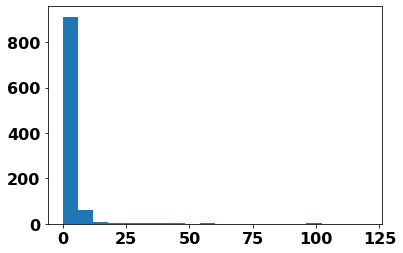

In [32]:
a = np.hstack(price_diff)
plt.hist(a, bins=20)
plt.show()

In [33]:
def price_likely_match(abs_diff):
    price_diff_list = price_diff[:]
    price_diff_list.sort()
    i = 0
    while price_diff_list[i] < abs_diff:
        if i == len(price_diff_list) - 1:
            return 0
        i += 1
    return 1 - i/len(price_diff_list)

def price_likely_matches(n):
    pass

#price_likely_match(10)

In [54]:
def get_n_matches(n, fn_likely_matches):
    likely_matches = []
    i = 0
    while len(likely_matches) != n:
        m = fn_likely_matches(i)
        if m['zalando_id'] != None:
            likely_matches += [fn_likely_matches(i)]
        i += 1
    return likely_matches

#brand_matches = get_n_matches(10, brand_likely_matches)
#title_matches = get_n_matches(len(matches_training_df), title_likely_matches)
#color_matches = get_n_matches(20, color_likely_matches)
#descr_matches = get_n_matches(100, descr_likely_matches)

In [55]:
def is_present(predicted_match):
    zalando_id = predicted_match['zalando_id']
    return len(matches_training_df.loc[matches_training_df['zalando'] == zalando_id]['aboutyou'])

def print_attributes_values(z_id, a_id, attribute):
    z_a = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id][attribute].values[0]
    a_a = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id][attribute].values[0]
    print(z_a, '-', a_a)

def is_match(predicted_match):
    zalando_id = predicted_match['zalando_id']
    df_not_matched = pd.DataFrame(columns=['zalando', 'aboutyou'])
    if is_present(predicted_match):
        match = matches_training_df\
        .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
        
        aboutyou_match_truth_id = matches_training_df\
                        .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
     
        isin = match in predicted_match['aboutyou_ids']
        row = {}
        if not isin:
            row = {'zalando':zalando_id, 'aboutyou': match}
            print_attributes_values(zalando_id, aboutyou_match_truth_id, 'offer_id')
            pass
        return isin, row
    return None

def print_weight(str_feature, matches):
    print(str_feature + ' matching:', 
      calc_match_rate(matches),
      'over:', len(matches), 'matches,',
      'accuracy:', calc_match_accuracy(matches)
     )
    
def calc_match_rate(matches):
    l = []
    df_not_matched = pd.DataFrame(columns=['zalando', 'aboutyou'])
    for i in range(len(matches)):
        is_m, row = is_match(matches[i])
        l += [is_m]
        if not is_m:
            df_not_matched = df_not_matched.append(row, ignore_index=True)
    return l.count(True) / len(matches), df_not_matched

def calc_match_accuracy(matches, scale=1000):
    return scale / np.mean([len(matches[i]['aboutyou_ids']) for i in range(len(matches))])



#print_weight('brand', brand_matches)
#print_weight('title', title_matches)
#rate, title_not_matched = calc_match_rate(title_matches)
#print_weight('color', color_matches)
#print_weight('descr', descr_matches)
#title_not_matched

9d597a50-de65-443e-b47f-68dc7315dc0d - d787814a-acd1-4212-87f2-bb36696e15a0
7b24117d-2e01-4b2a-84da-11a40c3f58de - 807d86a1-77af-4f7b-b4d2-cc06f930d03f
aa9700a6-b08a-4245-93d1-b60badc5302f - ce18ecf8-fe93-40bf-b4c0-82c2a0d21751
4cb90af3-2cec-4999-b7be-0f3967d378a1 - da94c5e6-ba37-43a7-bc85-be7a51fdbb8b
38c520ba-761c-44c7-bcc8-1e3c78578853 - 518ca595-f9c0-4201-8c5d-a3af1492849a
4b2f3907-1611-4dc2-87b1-c79b9c3cc7f9 - a04ac7a7-125d-4329-a55f-7854286d3279
e4ef648f-2d83-40b1-90f2-eabea9b8da9a - 4fd94251-7458-4c49-ada7-795bdb90f68e
bbf7b672-0b6f-4531-9bbd-128bcaa35b5b - 6d754ab5-7a62-48ac-a0cc-f82dea10e9e4
47b4eeed-8854-42fa-b521-70774f32b108 - fa8e54e6-66fb-4a0f-a37e-0e3f3f0a709a
8e28061d-7bf7-4dfe-b2c4-26861eaf1604 - f966eb83-909a-45b6-837f-8d443e96384f
42b3c70a-38a7-476e-ab2b-4f91bc04b1e5 - f976cb58-8446-4342-bc4b-a7f5676dcd82
51cfbaf5-2463-492f-833b-4f784711ccc5 - f879c228-1a35-41f3-a6c9-58777bb0061e
337a966a-f422-4252-829b-00a60b675ca6 - 57989f77-6c67-45c2-9e97-fb1bc75fed38
7e191b1e-4c6

27ff32ad-df58-41ff-aeac-1481389fe04a - b4308f93-6305-4f57-94b6-8353ca9ce426
be1852be-e0b1-47b7-abda-579e871b953e - e59ae993-834c-45d2-93ca-5576b78f181e
25af2d1c-d65d-49c4-b47b-55aead99f510 - eff47161-5332-484c-853a-1b452e2ab1f9
266485db-8adf-430a-b4ba-b1092a3161b6 - c5db2446-4d16-4910-9ec2-b33641cd48cf
ad191665-aee9-4b17-a265-85cc25d9b270 - 7c944573-e7bc-4f70-9087-fd72342dbf41
1479b718-e633-48e3-86f6-0db458957b0e - 42f501ec-1612-4ac8-a36f-448534046174
73953ce5-670f-424e-a15b-af3742de363b - 139fac02-e7e9-46eb-a81a-9db32772151b
f2a40daf-5245-4003-989f-cde6aa79fcf8 - 66bc4859-89e9-4647-9a37-7e808bf9e18f
3fba779f-68a2-4910-a2d9-5c44e9cd1a0b - 0285c6f5-b710-4c8e-8130-4d24605f3c24
7800e00a-bae6-4122-bdf7-cf9d33420cc7 - 5fe7d3c6-538c-4ae0-9f4e-5b3bcf7cea32
9d813669-7722-4185-9ac1-4a789bde96c8 - fbc36ad8-fb2b-4563-a8fb-84afecc30476
4bd5b817-3123-411c-83b6-e037b14ec9c2 - bd7dcb05-010a-4a0e-b51a-9fff0beed9d3
e46728b1-4474-40b6-9b26-2853a7666f8a - ec361fb2-cdce-4fba-9329-eb457e492692
5ef36de1-f4e

143c0d92-1b27-4ff0-a69e-4c73570f9e1d - 4db1b2cf-d831-467d-aa4c-9a4a7874a042
7f41aad5-6cbe-44bc-af78-8cc8ca6809a8 - cbfd7130-157b-4602-9a7a-6b99385062ba
8075eca0-2e8a-4386-a107-b32876bdd29d - 046b3461-9df4-4906-b5f5-51bec1064f73
3335a98d-0ada-40e1-aef4-2c2712123772 - ae6978e3-e297-4c49-b0f2-9c2cdc0c6e7b
6347b6a6-6a14-480d-a5e5-0a77f76fb5ce - aa281fa1-8d63-41c6-961d-6523df6abccb
236e685d-eaf8-4ced-aab6-38da5640ea8e - f51b37d2-a89c-4908-8826-bd16950b5f02
4a8728f1-61fb-4c00-b078-07c2bb8fbf49 - f38207f1-d117-48a6-be7d-c393066a5a33
4f115766-d8c5-4d10-b7ac-f76e60a407b3 - 43f12879-ca64-477f-a077-406bf5d08c2c
389cfdcd-8b64-498d-9b9b-7a1d149b05c7 - 7d7a37c0-7d6d-48d0-80d7-4e495659e9ee
fd3ec181-80b1-4dcf-bbe2-51d8245fd9c3 - ce6e3ee5-a2b0-4329-a4e3-3a6953133c45
793e922c-110f-4d33-ab22-6a2f29bd3cb1 - 9bb3b801-1aad-460e-8dc0-2fe5c936cc7b
51721a28-b0b1-4b9e-9b34-066b1d56f1de - ae4189cb-c575-46f6-9aad-7d3e43166b3e
12c034d6-c860-40e5-93fb-8099c0adc1e1 - 1cad7fb6-491f-48e8-81d5-2125ec52bafb
bb99ce0a-933

30a857de-49f6-480d-9824-b05dbdca0c13 - e8627904-976f-45ee-b5a6-05005c63c406
6f555693-6213-481f-8398-d6beb08b437b - e96d8644-2a94-4f16-a805-0b75c076f47b
6bf3d186-f8e8-4447-b033-15207bc02c78 - 9316e31c-5a15-4fd5-a188-f9b82446a24f
1cd8a5eb-654c-4188-80ff-665ec46ea754 - a1410803-5590-4c17-8896-e1a2f747ef93
494e55cd-85c2-4e02-90a0-01ee0dfbc3e6 - 7ad7f50b-f0e3-464f-b323-08d79c5982fc
7dec48ab-4565-4f2c-b7be-d8f30033e668 - 3c151df7-7398-4aa4-a5f1-c430ea85786e
ff7152b8-d3a6-4683-96cd-6f60b5ae0536 - 7efda8c0-712e-4bba-b599-46981df55cc0
29ffe4d1-c298-473c-a6da-b568e2a828c0 - c0595145-bf4c-4d86-86e1-dfb4b07da767
6d26bbf4-7b91-4a58-a584-304355ee6992 - 8641a047-c682-41b4-a307-230b4dedf756
e33fd72b-d57f-4044-af41-847cd2209cf1 - 4f49bb82-8653-4af6-9abd-8c21fd284786
8c145aba-03c3-4847-8af3-7ccd95579800 - c0485c7f-bea6-49f5-ab21-5cf0426c39e6
7ee3ad44-2866-4dbe-a407-58bf04169986 - ca78f9b4-7693-4928-bf0f-fbaa0a8f5087
03cf99a5-aae5-4c25-bd52-9beb6b9c73e9 - aebe10fe-0567-4228-8111-f49c5772720d
40786d4f-d45

56820557-d427-4687-922d-b7060e02b44b - 6f88f324-dd50-47e9-a6bc-30c1df69b9b2
766e45f2-3748-406a-8df1-feb71f01e018 - 884b1001-e6e5-4e81-8695-b71bfa0322e3
36171022-b912-4389-bada-bbc50d267932 - f5e391f6-4dfb-4e04-aa3c-5c21066ad68d
0306d815-28f1-403a-bb27-972b7446daff - 9c677c87-4e7b-47be-a429-e30c694d814f
5da0a70f-a70a-4a70-a8d5-c7f2338343d3 - d06197e6-8f62-414f-9203-fdb6c822d34e
54c405a3-3a68-42dd-ada1-e68086c783b4 - 06404f59-5206-4486-a31e-c8eda609a684
86cc5727-4f8c-42ea-a2f3-a1c064969c0a - b75f0bb2-eb72-4a59-af50-a4790a534570
093a2745-96e3-483b-b81e-847d3e336f73 - 3b17eb15-70b5-40e4-9eaf-2d0eed4c2399
17ae2909-df11-43b9-860c-7e31a56cc527 - 39b45496-0e05-42c1-b166-3b904cf898fb
ded11261-75d3-495a-af58-af1adbfc85e9 - 991fe331-9713-46a4-a92f-a2219e4a88ad
7d936d22-5af9-4bc9-8ff3-34fd72c99617 - 4140b2ff-8188-4d41-8e88-8f2a1742107c
bd9072fb-135e-466b-80fc-b77fa8e3cf04 - 094cbc1f-db12-4be5-b03e-adc8fd2b87e9
91526f02-e699-44b2-b6e7-73ced574db84 - 8e3c0656-e5ef-43f4-b116-b814f26fe035
748c5898-ae0

75904f52-3a89-4937-9110-9d0486f06bf7 - 7a69627c-4a4b-464d-9dd6-5d1f83150193
71b698fb-d810-4f73-abd9-51f8ae9474ec - a0b0d63a-bb45-42d2-b141-92c8c0d599b4
37da1fbd-7a0b-4a18-be32-6679f83cb634 - f497490e-6f75-4868-87ec-cd6772e883ed
96abb02a-6485-46a3-83eb-63a833b1f59a - fc9d502c-822e-43e3-88e6-9d224ce35274
553b449b-4175-4cae-af98-244f79905f74 - 8306b48b-9e1d-4b8e-a6b2-5ed223b4a812
a53fba62-1f81-4366-9567-4467dd5510a5 - 214ab777-c67c-4842-8098-e927b9994174
d98adb87-f241-4cfd-a387-b76d23ef7248 - ad1bfda8-0b52-4f7a-a67a-4d4cbbe12958
a63ae1e0-9622-4034-aa8f-2af104b86b05 - e605acad-1d3f-4639-904f-d89145c21d3d
c15ba4ff-c91e-4db6-91de-c97685c7d265 - 279f03d3-f503-4d37-adfb-611512a6894e
ec2e021f-18e0-45a3-806e-ae471af9e08e - 218863c8-be69-4a6c-97f5-e750dec158d8
63f994ed-25ad-4fb6-b6f9-b21f513f3331 - 44a03f1d-972c-4747-955d-f394d4a31658
0e962ca4-39ed-45fa-a535-904517f1b3e9 - a6e7add6-62cf-42ff-8eab-f07126956803
f768d3f8-bd5d-4798-8ad6-c7a167c14e32 - d9e45f89-9be2-4ba2-962f-5186a0a92f0f
d0e139b2-8f1

b32a606c-2eb0-41c0-a522-e76157bdd812 - 994d74ae-197c-482f-a78f-60d320013d73
a55f072d-fb38-4662-9e8d-a58741b8f78c - 7d8f8567-f7b6-4d11-8548-f48050a23c4a
0ceeb838-263c-4e43-9da2-5a58b785ffcb - 5ac5a6bf-c599-49bb-9423-8e611f99ddca
cd9cd652-6b68-4b8b-9cb8-e1109cf3b54d - 667b1ee5-9820-4a9e-a1ab-1bccd657e75c
c946ec30-6d26-467e-8fcf-dfbb529f2acf - 45a3bc81-1c11-4f1c-a634-62d7c1ac9ce1
6ce2567f-9818-4e51-b889-6d93a8bf8427 - 739e00c7-82a1-4913-bd64-e8c377458f94
903414c7-2200-4278-9438-e26d410a1ebe - 735d74f8-79d5-4c0d-8336-0684ebd7c49c
b8efd942-7b1d-47d6-93bc-3ae7c3c143ae - a5dffc05-4509-4250-acc2-ad225e8f2ebc
b1f3e6e6-951f-49d3-ba61-e98acfb47794 - 002ea379-0054-4b19-b999-e6fc440387bb
5c8c8d33-d5f6-4889-98f5-d25255f08df4 - 842511be-13a6-41dc-8489-544db51a637a
fb5487fc-e02f-468b-8560-84f24635170e - 27e8aacd-0bbc-4d96-8d3d-56d67df50334
91884a8e-e48e-4504-9de7-cb0b5c9250fa - cfaa9c08-7a23-40f7-b293-cfbb8b99fadc
38268351-e272-46ea-a5b5-07555b6da6a6 - 61787cef-2ad1-4dc1-a08f-584675dd4c04
5ee061c3-dde

,zalando,aboutyou
0,9d597a50-de65-443e-b47f-68dc7315dc0d,d787814a-acd1-4212-87f2-bb36696e15a0
1,7b24117d-2e01-4b2a-84da-11a40c3f58de,807d86a1-77af-4f7b-b4d2-cc06f930d03f
2,aa9700a6-b08a-4245-93d1-b60badc5302f,ce18ecf8-fe93-40bf-b4c0-82c2a0d21751
3,4cb90af3-2cec-4999-b7be-0f3967d378a1,da94c5e6-ba37-43a7-bc85-be7a51fdbb8b
4,38c520ba-761c-44c7-bcc8-1e3c78578853,518ca595-f9c0-4201-8c5d-a3af1492849a
...,...,...
663,5c8c8d33-d5f6-4889-98f5-d25255f08df4,842511be-13a6-41dc-8489-544db51a637a
664,fb5487fc-e02f-468b-8560-84f24635170e,27e8aacd-0bbc-4d96-8d3d-56d67df50334
665,91884a8e-e48e-4504-9de7-cb0b5c9250fa,cfaa9c08-7a23-40f7-b293-cfbb8b99fadc
666,38268351-e272-46ea-a5b5-07555b6da6a6,61787cef-2ad1-4dc1-a08f-584675dd4c04


In [58]:
#title_not_matched.to_parquet('title_not_matched.parquet')
#len(title_not_matched)/len(matches_training_df)

0.04403427818061965

In [36]:
def get_rank_score(el_list, el):
    try:
        rank = el_list.index(el)
    except:
        return 0
    return (len(el_list) - rank) / len(el_list)

In [37]:
def calculate_match_score(zalando_offer_id, aboutyou_offer_id, subset_offers=[]):

    zalando_offer = zalando_prod_training.loc[zalando_prod_training['offer_id'] == zalando_offer_id]
    aboutyou_offer = aboutyou_prod_training.loc[aboutyou_prod_training['offer_id'] == aboutyou_offer_id]
    zalando_index = zalando_offer.index.values[0]
    
    brand_weight = 1
    brand_matches = subset_offers#brand_likely_matches(zalando_index)
    #brand_in = aboutyou_offer_id in brand_matches['aboutyou_ids']
    brand_in = aboutyou_offer_id in brand_matches
    brand_score = int(brand_in)
    
    title_weight = 1
    title_matches = subset_offers#title_likely_matches(zalando_index)
    #title_score = get_rank_score(title_matches['aboutyou_ids'], aboutyou_offer_id)
    title_score = get_rank_score(title_matches, aboutyou_offer_id)
    
    color_weight = 1
    color_matches = subset_offers#color_likely_matches(zalando_index)
    #color_score = get_rank_score(color_matches['aboutyou_ids'], aboutyou_offer_id)
    color_score = get_rank_score(color_matches, aboutyou_offer_id)
    
    price_weight = 1
    z_p, a_p = zalando_offer['price'].values[0], aboutyou_offer['price'].values[0]
    price_diff = np.abs(z_p - a_p)
    price_score = price_likely_match(price_diff)
    
    score = brand_score * brand_weight +\
            title_score * title_weight +\
            color_score * color_weight +\
            price_score * price_weight
    return score

#calculate_match_score('b33f55d6-0149-4063-8b63-3eeae63562a2', 'ad5ceb87-0254-4171-b650-1d4d09f48efc')

In [38]:
#To limit the results and improve time efficency
def get_matches(z_id):
    zalando_offer = zalando_prod_training.loc[zalando_prod_training['offer_id'] == z_id]
    brand_name = zalando_offer['brand'].values[0]
    match_brands = brand_collection.get_match(brand_name)[0]
    
    #Brand Match
    aboutyou_prod_brand_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['brand']\
                                .isin(match_brands)]['offer_id'].values)
    
    #Title Match
    match_titles_relevance = list(dict.fromkeys(bm25matcher_title.get_relevant_results(zalando_offer['title'].values[0])))
    match_titles = [x.text for x in match_titles_relevance]
    aboutyou_prod_title_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['title']\
                                .isin(match_titles)]['offer_id'].values)
    
    #Color Match
    match_color_relevance = list(dict.fromkeys(bm25matcher_color.get_relevant_results(zalando_offer['color'].values[0])))
    match_color = [x.text for x in match_color_relevance]
    aboutyou_prod_color_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['color']\
                                .isin(match_color)]['offer_id'].values)
    
    match_intersect_set = aboutyou_prod_brand_match\
                            .intersection(aboutyou_prod_color_match)\
                            .intersection(aboutyou_prod_title_match)
    
    return match_intersect_set

In [39]:
def get_best_match(z_id, a_ids_list, limit=1):
    df_score = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    for id in a_ids_list:
        row = {'zalando':z_id, 'aboutyou': id, 'score': calculate_match_score(z_id, id, a_ids_list)}
        df_score = df_score.append(row, ignore_index=True)
    return df_score.sort_values(by=['score'], ascending=False).head(limit)


#m = get_best_match('b33f55d6-0149-4063-8b63-3eeae63562a2', matches_training_df['aboutyou'].values[0:1000])

In [40]:
def create_matches_df(z_ids_list, result_per_item=10):
    df_predicted_matches = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    df_best_n_matches = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    for z_id in z_ids_list:
        subset_comp = get_matches(z_id)
        prediction = get_best_match(z_id, subset_comp, result_per_item)
        df_predicted_matches = df_predicted_matches.append(prediction.head(1), ignore_index=True)
        df_best_n_matches = df_best_n_matches.append(prediction, ignore_index=True)
        #print(len(prediction))
        #print(len(df_best_n_matches))
    return df_predicted_matches, df_best_n_matches

In [41]:
start = time.time()
pred, best_n_matches = create_matches_df(list(matches_training_df['zalando'].values)[:10])
get_matches(list(matches_training_df['zalando'].values)[0])
end = time.time()
print('Computation time:', round(end-start, 4), 'sec')

Computation time: 17.5358 sec


In [42]:
get_metrics(
            matches_training_df.loc[:len(pred)+1], 
            pred, 
            best_n_matches, 
            aboutyou_prod_training, 
            matches_training_df
           )

{'TP': 1,
 'FN': 11,
 'FP': 9,
 'TN': 61959,
 'positives': 12,
 'negatives': 61968,
 'precision': 0.1,
 'recall': 0.08333333333333333,
 'F1': 0.0909090909090909,
 'PS': 10.0,
 'P3': 30.0,
 'P5': 50.0,
 'P10': 60.0}

Zalando: BRAND=Swarovski                     TITLE=LIFELONG BANGLE  Armband                     COLOR=roségoldfarben                     PRICE=99.6854545454545


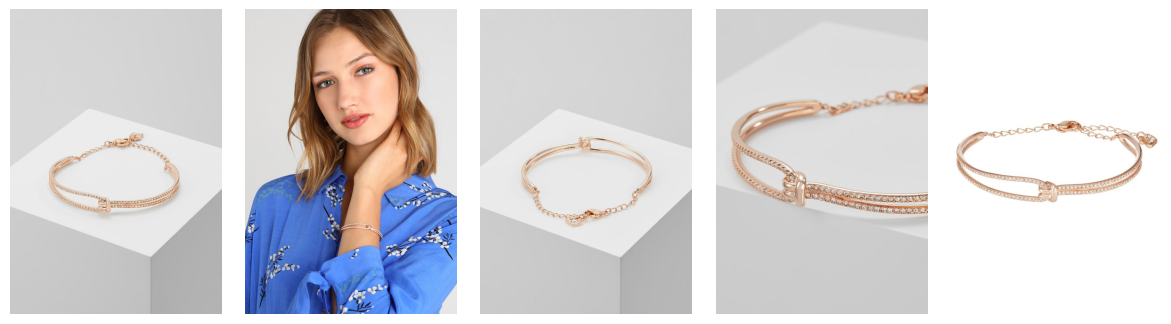

Predicted Aboutyou: BRAND=Swarovski                     TITLE=Ring 'Lifelong'                     COLOR=rosegold | silber | transparent | Gold                     PRICE=99.9


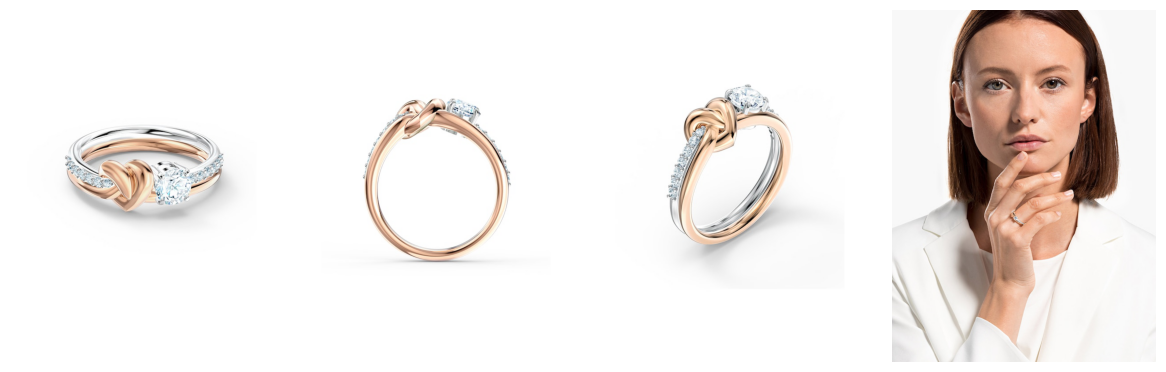

Prediction non correct, actual prediction:
True Aboutyou: BRAND=Swarovski                     TITLE=Armreif                     COLOR=rosegold | Gold                     PRICE=115.0


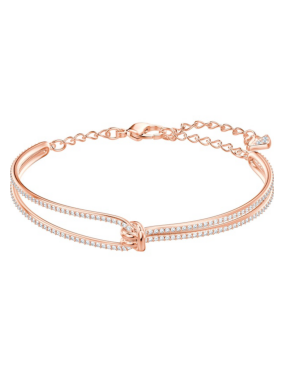

In [43]:
explore_match(pred.loc[1], matches_training_df)